# Music Taste Prediction Model: New Music Friday Recommender 💿🎧👍👎
In this model, I use my liked songs playlist, my recently loved and not loved albums, to train my regression model on what kind of music I do and don't like. At the end my test model will be the new music friday albums from the most recent Friday. 

# Library Imports

In [4]:
# Standard Library Imports
import os
import csv
from datetime import datetime
from time import sleep
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict, Tuple, Optional

# Third-Party Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from textblob import TextBlob
from transformers import pipeline

# Fuzzy Matching
from fuzzywuzzy import fuzz, process

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform

# Network Analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
from nbconvert import HTMLExporter
import nbformat

# Streamlit 
import streamlit as st

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')


# Load Datasets

In [6]:
df_liked = pd.read_csv("data/liked.csv")  # Liked playlist on Spotify
df_fav_albums = pd.read_csv("data/liked_albums.csv")  # Albums I've Liked in Recent Years
df_not_liked = pd.read_csv("data/did_not_like.csv")  # Albums I've not liked in Recent Years
df_nmf = pd.read_csv("data/nmf.csv")  # The most recent New Music Friday Playlist
df_mid = pd.read_csv("data/mid.csv") #Albums I neither enjoyed or hated, but were simply Mid
df_liked_similar = pd.read_csv('data/liked_artists_only_similar.csv') #Similar Artisits to My Liked Artists

## A Check for New Artists / Pull Their Similar Artists

In [8]:
# Initialize LastFM API client with rate limiting and request limits
# This ensures we don't overload the API and stay within usage guidelines ⏳
class LastFMAPI:
    def __init__(self, api_key: str, rate_limit_delay: float = 0.25, limit: int = 5):
        self.api_key = api_key
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.rate_limit_delay = rate_limit_delay
        self.limit = limit

    # Fetch similar artists for a given artist from LastFM API
    # This is the core function that interacts with the API 🎤
    def get_similar_artists(self, artist_name: str) -> List[str]:
        params = {
            'method': 'artist.getSimilar',
            'artist': artist_name,
            'api_key': self.api_key,
            'limit': self.limit,  # Limit the number of similar artists returned 🎯
            'format': 'json'
        }
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            
            # Handle rate limiting to avoid API bans ⚠️
            if 'X-RateLimit-Remaining' in response.headers:
                remaining = int(response.headers['X-RateLimit-Remaining'])
                if remaining == 0:
                    sleep(self.rate_limit_delay)
            
            # Extract and return similar artists from the API response 🎶
            data = response.json()
            if 'similarartists' in data and 'artist' in data['similarartists']:
                return [artist['name'] for artist in data['similarartists']['artist'][:self.limit]]
            return []
            
        except Exception as e:
            print(f"Error fetching similar artists for {artist_name}: {e}")
            return []

# Extract the primary artist name from a string
# This handles cases where multiple artists are listed (e.g., "Artist A, Artist B") 🎤
def extract_primary_artist(artist_string: str) -> str:
    if pd.isna(artist_string):
        return ""
    return artist_string.split(",")[0].strip()

# Update the similar artists database with new artists from liked playlists
# This function ensures the database stays up-to-date with my latest music preferences 🔄
def update_similar_artists(liked_path: str, 
                         albums_path: str, 
                         output_path: str, 
                         api_key: str) -> pd.DataFrame:
    print("Loading existing and new data...")
    
    # Load existing similar artists data
    # This ensures we don't duplicate work for artists already in the database 📂
    existing_data: Dict[str, List[str]] = {}
    if os.path.exists(output_path):
        existing_df = pd.read_csv(output_path)
        existing_data = dict(zip(existing_df['Artist'], existing_df['Similar Artists']))
        print(f"Loaded {len(existing_data)} existing artists from database")
    
    # Load and process current playlists
    # This combines liked songs and albums into a single set of artists 🎧
    df_liked = pd.read_csv(liked_path)
    df_albums = pd.read_csv(albums_path)
    
    # Extract and combine primary artists
    current_artists = set(
        pd.concat([
            df_liked['Artist Name(s)'].apply(extract_primary_artist),
            df_albums['Artist Name(s)'].apply(extract_primary_artist)
        ]).unique()
    )
    current_artists.discard("")  # Remove empty strings
    
    # Find new artists not in existing data
    # This ensures we only process artists we haven't seen before �
    new_artists = current_artists - set(existing_data.keys())
    print(f"Found {len(new_artists)} new artists to process")
    
    if not new_artists:
        print("No new artists to process. Database is up to date!")
        # Create and return DataFrame even if no updates
        return pd.DataFrame({
            'Artist': list(existing_data.keys()),
            'Similar Artists': list(existing_data.values())
        })
    
    # Initialize LastFM API client
    # This is where the magic happens ✨
    api = LastFMAPI(api_key)
    
    # Process artists with concurrent requests
    # This speeds up the process by fetching data in parallel ⚡
    results = {}
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_artist = {
            executor.submit(api.get_similar_artists, artist): artist 
            for artist in new_artists
        }
        
        # Show progress bar while processing
        # This keeps you informed about the progress of the task 📊
        for future in tqdm(as_completed(future_to_artist), 
                         total=len(future_to_artist),
                         desc="Fetching similar artists"):
            artist = future_to_artist[future]
            similar_artists = future.result()
            results[artist] = ', '.join(similar_artists)
    
    # Combine existing and new data
    # This ensures the final dataset includes all artists, old and new 🔗
    combined_data = {**existing_data, **results}
    
    # Create DataFrame
    # This formats the data for easy saving and future use 📄
    output_df = pd.DataFrame({
        'Artist': list(combined_data.keys()),
        'Similar Artists': list(combined_data.values())
    })
    
    # Save updated data
    # This ensures the database is persisted for future runs 💾
    output_df.to_csv(output_path, index=False)
    print(f"Successfully updated database with {len(new_artists)} new artists")
    print(f"Total artists in database: {len(combined_data)}")
    
    return output_df

# Main execution block
# This runs the update process when the script is executed directly 🚀
if __name__ == "__main__":
    # Configuration
    API_KEY = "74a510ecc9fc62bf3e0edc6adc2e99f9"
    LIKED_PATH = "data/liked.csv"
    ALBUMS_PATH = "data/liked_albums.csv"
    OUTPUT_PATH = "data/liked_artists_only_similar.csv"
    
    # Run the update and get the DataFrame
    df_liked_similar = update_similar_artists(
        LIKED_PATH, 
        ALBUMS_PATH, 
        OUTPUT_PATH, 
        API_KEY
    )
    
# Now df_liked_similar is ready to use
df_liked_similar.head()

Loading existing and new data...
Loaded 2207 existing artists from database
Found 0 new artists to process
No new artists to process. Database is up to date!


,Artist,Similar Artists
0,RY X,NaN
1,The Faim,"Oh The Larceny, City Wolf, Random Hero, needsh..."
2,Melody Lake,"Ian Wong, Limelight Glow, Slow Rising Hope, Po..."
3,Liza Anne,"Miya Folick, Torres, Billie Marten, Pom Pom Sq..."
4,The Kinks,"Dave Davies, The Who, Small Faces, The Zombies..."


## Quick Glance at our Refreshed Datasets

In [10]:
df_liked.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,4qkVALwOxCIEZ7I5gkZ3m4,Butterfly,Butterfly,UMI,2018-03-09,160500,54,NaN,2025-03-27T13:15:30Z,NaN,...,5,-14.457,1,0.0892,0.255000,0.001320,0.0953,0.1200,131.894,4
1,1Vrw7LZl56M8akId20D455,Show Runner 99,Sunny Boy,Ritt Momney,2021-10-22,206316,34,NaN,2025-03-27T12:56:20Z,bedroom pop,...,6,-10.143,1,0.0332,0.916000,0.003450,0.3300,0.3150,127.465,5
2,6jJ8MYemaVVoXwMtt8W9Y3,Wretched Trajectory,Feeling Not Found,Origami Angel,2024-09-27,166050,38,NaN,2025-03-27T12:23:13Z,"midwest emo,math rock,indie punk,emo pop,emo",...,1,-2.745,1,0.0416,0.000058,0.000418,0.3250,0.7020,130.019,4
3,0S8sdHhetOnbep0lpwbVV1,Buoyant,Underneath,Floodlights,2025-03-21,249059,35,NaN,2025-03-24T00:03:56Z,NaN,...,11,-9.711,0,0.0374,0.291000,0.005010,0.1100,0.0734,200.208,4
4,7Jrm4sannMTjBpwl0Usxzu,Bees and Swans,Ancient Transition,Beta Radio,2018-09-14,250226,29,NaN,2025-03-22T19:02:46Z,indie folk,...,9,-8.025,1,0.0313,0.777000,0.001290,0.2240,0.2750,144.478,3


In [11]:
# Liked Albums in Recent Years
df_fav_albums.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,0UOeq7bSskoJa4cJaJOmFS,Ticking,Letter to Self,SPRINTS,2024-01-05,186949,30,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,11.0,-6.490,1.0,0.3440,0.02500,0.076500,0.0934,0.291,175.574,4.0
1,02bA26OEe0nNFyE3YcNx4K,Heavy,Letter to Self,SPRINTS,2024-01-05,207409,48,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,11.0,-5.925,1.0,0.0591,0.00435,0.000738,0.0877,0.189,88.581,4.0
2,7IPDhCIQlpvxVxtC1Q7Jq4,Cathedral,Letter to Self,SPRINTS,2024-01-05,179694,31,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,7.0,-6.231,1.0,0.0473,0.00978,0.002700,0.0887,0.397,119.056,4.0
3,65fPteG9ctHt2rrJxlbMr8,Shaking Their Hands,Letter to Self,SPRINTS,2024-01-05,222489,29,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,4.0,-5.658,0.0,0.0533,0.19900,0.108000,0.1330,0.551,89.485,4.0
4,4UgkFdXpJD0fhw06BMk0bz,Adore Adore Adore,Letter to Self,SPRINTS,2024-01-05,157766,38,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,4.0,-4.401,0.0,0.2570,0.01070,0.000107,0.1010,0.402,176.054,4.0


In [12]:
# Albums Not Liked in Recent Years
df_not_liked.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,54KEm0VI9i3ic7VHHKHKRx,¿Cómo Así?,ORQUÍDEAS,Kali Uchis,2024-01-12,169654,59,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,6.0,-7.662,0.0,0.0892,0.04170,0.346000,0.154,0.379,135.985,4.0
1,5mVkTPlTPxlQOn7kEvuM3j,Me Pongo Loca,ORQUÍDEAS,Kali Uchis,2024-01-12,177815,57,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,7.0,-8.680,0.0,0.0426,0.03710,0.152000,0.106,0.407,114.999,4.0
2,6XaJfhwof7qIgbbXO5tIQI,Igual Que Un Ángel (with Peso Pluma),ORQUÍDEAS,"Kali Uchis,Peso Pluma",2024-01-12,260370,78,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,"corrido,corridos tumbados,corridos bélicos,mús...",...,5.0,-5.340,0.0,0.0320,0.00449,0.000663,0.185,0.482,108.001,4.0
3,52x8HIGuk1gGTlvO8CuLNS,Pensamientos Intrusivos,ORQUÍDEAS,Kali Uchis,2024-01-12,192027,63,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,9.0,-8.333,0.0,0.0394,0.57500,0.012900,0.110,0.511,119.994,4.0
4,3RleMgz4iO0BNezGdSxDnY,Diosa,ORQUÍDEAS,Kali Uchis,2024-01-12,156037,62,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,5.0,-5.518,0.0,0.0668,0.06750,0.000101,0.078,0.698,107.994,4.0


In [13]:
#Albums I neither enjoyed or hated, but were simply Mid
df_mid.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,0eW1qPRpYEOhivcuNhpqzn,Totally Blue,Georgie,Twin Shadow,2025-03-14,183779,40,mmr4r23xnc6oh1c77lysfbqg4,2025-03-21T13:44:16Z,NaN,...,11,-9.777,1,0.0347,0.716,0.008000,0.1000,0.251,124.042,4
1,5U0U5yYXmFDlguWdk8kpv1,Good Times,Georgie,Twin Shadow,2025-03-14,176582,38,mmr4r23xnc6oh1c77lysfbqg4,2025-03-21T13:44:16Z,NaN,...,9,-4.492,1,0.0301,0.668,0.000374,0.1070,0.546,157.936,4
2,7yZnudvNop0nP8DrHxAxBF,As Soon As You Can,Georgie,Twin Shadow,2025-03-14,225384,37,mmr4r23xnc6oh1c77lysfbqg4,2025-03-21T13:44:16Z,NaN,...,10,-12.039,0,0.0431,0.722,0.001650,0.1090,0.187,77.793,4
3,67I1Z6RFau36Uh4FeXpUur,Funny Games,Georgie,Twin Shadow,2025-03-14,142702,35,mmr4r23xnc6oh1c77lysfbqg4,2025-03-21T13:44:16Z,NaN,...,2,-9.821,1,0.0671,0.762,0.094100,0.0994,0.322,145.989,4
4,3nd5lvsXMNxK8ch0Q52vNN,Geor(g.i.e.),Georgie,Twin Shadow,2025-03-14,95696,35,mmr4r23xnc6oh1c77lysfbqg4,2025-03-21T13:44:16Z,NaN,...,9,-17.813,1,0.0332,0.989,0.928000,0.0997,0.647,78.907,4


In [14]:
# New Music Friday Playlist
df_nmf.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,4mihgm7PkoBfslVD4bujOA,Calliope Prelude,Forever Is A Feeling,Lucy Dacus,2025-03-28,76817,0,jaytroymo,2025-03-28T05:49:34Z,NaN,...,9.0,-20.255,1.0,0.0478,0.895,0.199000,0.2700,0.0938,71.873,5.0
1,16aj4Y3ngJlxSpjXxcvnp4,Big Deal,Forever Is A Feeling,Lucy Dacus,2025-03-28,259216,0,jaytroymo,2025-03-28T05:49:34Z,NaN,...,9.0,-10.166,1.0,0.0314,0.518,0.000679,0.1320,0.1930,109.418,5.0
2,4VhbsGXRGDncpi79aiX8eE,Ankles,Forever Is A Feeling,Lucy Dacus,2025-03-28,191476,0,jaytroymo,2025-03-28T05:49:34Z,NaN,...,9.0,-6.940,1.0,0.0337,0.272,0.034800,0.0704,0.6900,120.021,4.0
3,6Ibl97BzvUovPw1FVXkETR,Limerence,Forever Is A Feeling,Lucy Dacus,2025-03-28,192452,0,jaytroymo,2025-03-28T05:49:34Z,NaN,...,2.0,-12.553,1.0,0.0374,0.946,0.000000,0.1370,0.4290,84.189,5.0
4,0yKWzCjbBGYGvbT88q8C6I,Modigliani,Forever Is A Feeling,Lucy Dacus,2025-03-28,186306,0,jaytroymo,2025-03-28T05:49:34Z,NaN,...,9.0,-9.757,1.0,0.0468,0.599,0.000056,0.1310,0.5430,111.060,4.0


In [15]:
# Similar Artists to Recently Played Artists (Last.fm)

df_liked_similar.head()

,Artist,Similar Artists
0,RY X,NaN
1,The Faim,"Oh The Larceny, City Wolf, Random Hero, needsh..."
2,Melody Lake,"Ian Wong, Limelight Glow, Slow Rising Hope, Po..."
3,Liza Anne,"Miya Folick, Torres, Billie Marten, Pom Pom Sq..."
4,The Kinks,"Dave Davies, The Who, Small Faces, The Zombies..."


> A quick reminder of the standard columns of a spotify export.

In [17]:
df_liked.columns

Index(['Track ID', 'Track Name', 'Album Name', 'Artist Name(s)',
       'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At',
       'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Time Signature'],
      dtype='object')

> What's available in the Similar dataframe?

In [19]:
df_liked_similar.columns

Index(['Artist', 'Similar Artists'], dtype='object')

### Add Target Labels for Training Feature
We need to assign a score to songs I've faved on spotify (100), albums I've enjoyed in recent years (65), albums that were mid (45), and albums that I have not enjoyed in recent years (30) to train the model on the types of songs I don't like, like, and love. 'liked' will be our target variable, later.

In [21]:
# Assign liked scores before combining
df_liked['liked'] = 100
df_fav_albums['liked'] = 65
df_mid['liked'] = 45
df_not_liked['liked'] = 30
df_nmf['liked'] = np.nan 

# Add playlist_origin column before combining
df_liked['playlist_origin'] = 'df_liked'
df_fav_albums['playlist_origin'] = 'df_fav_albums'
df_not_liked['playlist_origin'] = 'df_not_liked'
df_mid['playlist_origin'] = 'df_mid'
df_nmf['playlist_origin'] = 'df_nmf'
df_liked_similar['source'] = 'liked_similar'

### Check application of the target encoding

In [23]:
df_liked[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,100,df_liked
1,100,df_liked
2,100,df_liked
3,100,df_liked
4,100,df_liked


In [24]:
df_fav_albums[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,65,df_fav_albums
1,65,df_fav_albums
2,65,df_fav_albums
3,65,df_fav_albums
4,65,df_fav_albums


In [25]:
df_mid[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,45,df_mid
1,45,df_mid
2,45,df_mid
3,45,df_mid
4,45,df_mid


In [26]:
df_not_liked[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,30,df_not_liked
1,30,df_not_liked
2,30,df_not_liked
3,30,df_not_liked
4,30,df_not_liked


In [27]:
df_nmf[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,NaN,df_nmf
1,NaN,df_nmf
2,NaN,df_nmf
3,NaN,df_nmf
4,NaN,df_nmf


In [28]:
df_liked_similar[['Artist', 'Similar Artists', 'source']].head()

,Artist,Similar Artists,source
0,RY X,NaN,liked_similar
1,The Faim,"Oh The Larceny, City Wolf, Random Hero, needsh...",liked_similar
2,Melody Lake,"Ian Wong, Limelight Glow, Slow Rising Hope, Po...",liked_similar
3,Liza Anne,"Miya Folick, Torres, Billie Marten, Pom Pom Sq...",liked_similar
4,The Kinks,"Dave Davies, The Who, Small Faces, The Zombies...",liked_similar


## Data Cleaning 🧹
Before diving into modeling, I need to clean and prepare the data to ensure it’s ready for analysis. This section focuses on merging my datasets, handling duplicates, filling missing values, and making sure the data is in the best possible shape. Here’s what I’ll tackle:

1. **Merging Datasets**: I’ll combine my liked songs, favorite albums, not-liked albums, and New Music Friday tracks into a single dataframe.
2. **Removing Duplicates**: I’ll ensure each track is unique, prioritizing higher "liked" scores for duplicates.
3. **Handling Missing Values**: I’ll fill gaps in genres using Last.fm’s richer data and save a backup of missing artists for manual review later.
4. **Dropping Irrelevant Columns**: I’ll remove columns that won’t contribute to the model.
5. **Final Checks**: I’ll verify the dataset’s integrity and distribution before moving to modeling.

By the end of this section, I’ll have a clean, unified dataset ready for feature engineering and model training. Let’s get started! 🚀

## Merge The Datasets

In [31]:
df = pd.concat([df_liked, df_fav_albums, df_mid, df_not_liked, df_nmf], ignore_index=True)

In [32]:
#How Large is the Dataset, Now?
df.shape

(15521, 25)

#### Remove the Duplicates 🔥

In [34]:
# Remove duplicates: Keep the highest 'liked' score (100 > 65)
df = df.sort_values(by='liked', ascending=False)  # Ensures 100-rated songs come first
df = df.drop_duplicates(subset=['Track Name', 'Artist Name(s)'], keep='first')
df.shape

(12881, 25)

#### Drop columns that won't help the model 💣

In [36]:
df.drop(columns=['Added By', 'Added At', 'Time Signature'], inplace=True)

#### Handle missing values (if any)

In [38]:
 df.isna().sum()

Track ID               0
Track Name             0
Album Name             0
Artist Name(s)         0
Release Date           0
Duration (ms)          0
Popularity             0
Genres              6190
Record Label           3
Danceability          24
Energy                24
Key                   24
Loudness              24
Mode                  24
Speechiness           24
Acousticness          24
Instrumentalness      24
Liveness              24
Valence               24
Tempo                 24
liked                681
playlist_origin        0
dtype: int64

## Getting New Genre Data From Last.fm 🟢🎵
Since half of the genres are missing from Spotify songs, I decided to use the richer data from Last.fm's crowd-sourced genre tags. There are some silly tags in there, so I added a list of ignored tags that I update weekly based on what I see in the data. This ensures the genres are meaningful and relevant for my model.

In [40]:
class LastFMGenreFetcher:
    def __init__(self, api_key: str, rate_limit_delay: float = 0.25):
        self.api_key = api_key
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.rate_limit_delay = rate_limit_delay
        
        # Define tags to ignore
        # These are the crowd-sourced tags that are more about personal taste than actual genres
        self.ignored_tags = {
            'seen live',
            'albums i own',
            'favorite',
            'favourites',
            'favourite',
            'my playlist',
            'spotify',
            'pandora',
            'wish i had seen live',
            'awesome',
            'love at first listen',
            'love',
            'amazing',
            'listened',
            'personal',
            'my music'
        }
        
        # Define variations of female vocalist to standardize
        # Because Last.fm users love to tag the same thing in 10 different ways 🎤
        self.female_vocalist_variants = {
            'female vocalists',
            'female vocalist',
            'female vocals',
            'female fronted',
            'female voices',
            'female voice',
            'female singers',
            'female singer'
        }
        
        # Genre groups that typically appear together
        self.genre_compatibility = {
            'indie': ['indie pop', 'indie rock', 'indie folk', 'alternative', 'singer-songwriter'],
            'rock': ['alternative rock', 'indie rock', 'hard rock', 'classic rock', 'punk'],
            'electronic': ['techno', 'house', 'edm', 'ambient', 'idm', 'electronica'],
            'metal': ['heavy metal', 'death metal', 'black metal', 'thrash metal', 'doom metal'],
            'folk': ['indie folk', 'folk rock', 'americana', 'singer-songwriter', 'acoustic'],
            'pop': ['indie pop', 'synth pop', 'dream pop', 'electropop', 'pop rock'],
            'hip-hop': ['rap', 'trap', 'r&b', 'urban', 'grime'],
            'jazz': ['fusion', 'bebop', 'smooth jazz', 'soul', 'funk'],
            'classical': ['orchestral', 'chamber music', 'piano', 'instrumental', 'contemporary classical']
        }
        
        # This identifies genres that rarely appear together
        self.genre_incompatibility = {
            'classical': ['metal', 'rap', 'edm', 'techno', 'dubstep'],
            'death metal': ['pop', 'r&b', 'jazz', 'folk', 'ambient'],
            'christian': ['black metal', 'satanic', 'pagan'],
            'country': ['techno', 'edm', 'black metal', 'death metal'],
            'jazz': ['black metal', 'death metal', 'hardcore', 'screamo'],
            'k-pop': ['death metal', 'black metal', 'doom metal']
        }
        
    def _make_request(self, params: Dict)  -> Dict:
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            sleep(self.rate_limit_delay)  # Basic rate limiting to avoid angering the Last.fm API gods
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"API request failed for params {params}: {e}")
            if getattr(response, 'status_code', None) == 429:
                print("Rate limit exceeded, increasing delay. Patience is a virtue!")
                self.rate_limit_delay *= 2
                sleep(5)  # Wait before retry
            return None

    def get_artist_tags(self, artist_name: str) -> List[str]:
        params = {
            'method': 'artist.getTopTags',
            'artist': artist_name,
            'api_key': self.api_key,
            'format': 'json'
        }
        data = self._make_request(params)
        
        if not data or 'toptags' not in data:
            return []  # Sometimes Last.fm just doesn't have the data 🤷‍♂️
            
        tags = []
        seen_tags = set()  # Track unique tags to avoid duplicates
        has_female_vocalist = False
        
        for tag in data['toptags'].get('tag', []):
            tag_name = tag['name'].lower()
            
            # Skip if tag is in ignored list
            if tag_name in self.ignored_tags:
                continue  # Bye-bye, irrelevant tags!
                
            # Handle female vocalist variations
            if tag_name in self.female_vocalist_variants:
                if not has_female_vocalist:
                    tags.insert(0, 'female vocalist')  # Standardize and prioritize this tag
                    has_female_vocalist = True
                continue
            
            # Only add tag if we haven't seen it before
            if tag_name not in seen_tags:
                tags.append(tag_name)
                seen_tags.add(tag_name)
                
        return tags[:10]  # Return up to 10 tags because less is more, right?
        
    def get_album_tags(self, artist_name: str, album_name: str, release_date: str = None) -> List[str]:
        """
        Get tags specifically for an album, with verification against artist tags.
        """
        # Try to get album-specific tags first
        params = {
            'method': 'album.getTopTags',
            'artist': artist_name,
            'album': album_name,
            'api_key': self.api_key,
            'format': 'json'
        }
        album_data = self._make_request(params)
        
        # Get artist tags for comparison
        artist_tags = self.get_artist_tags(artist_name)
        
        # Extract album tags if available
        album_tags = []
        if album_data and 'toptags' in album_data and 'tag' in album_data['toptags']:
            for tag in album_data['toptags'].get('tag', []):
                tag_name = tag['name'].lower()
                if tag_name not in self.ignored_tags:
                    album_tags.append(tag_name)
        
        # This verifies tags when we have both album and artist data
        if album_tags and artist_tags:
            verified_tags = self._verify_tags(album_tags, artist_tags, release_date)
            return verified_tags[:10]
        elif album_tags:
            return album_tags[:10]
        else:
            return artist_tags[:10]
    
    def _verify_tags(self, album_tags: List[str], artist_tags: List[str], release_date: str = None) -> List[str]:
        # Convert to sets for easier comparison
        album_tag_set = set(album_tags)
        artist_tag_set = set(artist_tags)
        
        # Calculate overlap between tags
        overlap = album_tag_set.intersection(artist_tag_set)
        overlap_ratio = len(overlap) / len(album_tag_set) if album_tag_set else 0
        
        # This means we have good tag agreement
        if overlap_ratio >= 0.3:
            return album_tags
        
        # Check for incompatible genres
        for tag in album_tags:
            for incompatible_genre, incompatible_tags in self.genre_incompatibility.items():
                if tag == incompatible_genre:
                    for artist_tag in artist_tags:
                        if artist_tag in incompatible_tags:
                            # This indicates a likely mismatch
                            return artist_tags
        
        # Use release date as tiebreaker if available
        if release_date:
            try:
                year = int(release_date.split('-')[0])
                current_year = datetime.now().year
                
                # This prioritizes album tags for recent releases
                if year >= current_year - 2:
                    merged_tags = album_tags[:7] + [tag for tag in artist_tags if tag not in album_tag_set][:3]
                    return merged_tags
            except:
                pass
        
        # Merge tags with preference to album tags
        merged_tags = album_tags[:7] + [tag for tag in artist_tags if tag not in album_tag_set][:3]
        return merged_tags

def update_genre_data(api_key: str, dataframes: List[pd.DataFrame], output_file: str = 'data/ten_genres.csv') -> None:
    # Initialize the API client
    api = LastFMGenreFetcher(api_key)
    
    # Get all unique artist-album pairs from the dataframes
    artist_album_pairs = []
    for df in dataframes:
        if 'Artist Name(s)' in df.columns and 'Album Name' in df.columns and 'Release Date' in df.columns:
            pairs = df[['Artist Name(s)', 'Album Name', 'Release Date']].drop_duplicates()
            for _, row in pairs.iterrows():
                artist = row['Artist Name(s)'].split(',')[0].strip() if pd.notna(row['Artist Name(s)']) else None
                album = row['Album Name'] if pd.notna(row['Album Name']) else None
                release_date = row['Release Date'] if pd.notna(row['Release Date']) else None
                if artist and album:
                    artist_album_pairs.append((artist, album, release_date))
    
    # Load existing data
    existing_data = {}
    try:
        if os.path.exists(output_file) and os.path.getsize(output_file) > 0:
            existing_data = pd.read_csv(output_file).set_index(['Artist', 'Album'])['Genres'].to_dict()
    except (pd.errors.EmptyDataError, KeyError):
        print("No existing genre data found or file is empty. Starting fresh.")
    
    # Load obscure artist genres and merge
    obscure_artists = pd.read_csv("data/obscure_artists_mike_likes.csv", quotechar='"')
    obscure_artists_dict = {}
    for _, row in obscure_artists.iterrows():
        obscure_artists_dict[(row['Artist'], 'ANY_ALBUM')] = row['Genres']
    
    # Merge genres from obscure artists with existing data
    existing_data.update(obscure_artists_dict)
    
    # Identify new artist-album pairs that aren't in existing data
    new_pairs = [(artist, album, release_date) for artist, album, release_date in artist_album_pairs 
                if (artist, album) not in existing_data and (artist, 'ANY_ALBUM') not in existing_data]
    
    if not new_pairs:
        print("No new artist-album pairs to process!")
        return
    
    print(f"Found {len(new_pairs)} new artist-album pairs to process.")
    
    # Process new pairs with ThreadPoolExecutor
    results = {}
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_pair = {
            executor.submit(api.get_album_tags, artist, album, release_date): (artist, album) 
            for artist, album, release_date in new_pairs
        }
        
        completed = 0
        for future in as_completed(future_to_pair):
            artist, album = future_to_pair[future]
            try:
                tags = future.result()
                if tags:
                    results[(artist, album)] = ', '.join(tags)
                completed += 1
                if completed % 50 == 0 or (len(new_pairs) < 50 and completed % 10 == 0):
                    print(f"Processed {completed}/{len(new_pairs)} artist-album pairs.")
            except Exception as e:
                print(f"Error processing {artist} - {album}: {e}")
    
    # Combine existing and new data
    all_data = {**existing_data, **results}
    
    # Save to CSV with multi-index
    df_output = pd.DataFrame(
        [{'Artist': artist, 'Album': album, 'Genres': genres} 
         for (artist, album), genres in all_data.items()]
    )
    df_output.to_csv(output_file, index=False)
    print(f"\nSuccessfully updated {output_file} with {len(results)} new artist-album pairs!")

# Example usage:
if __name__ == "__main__":
    API_KEY = '74a510ecc9fc62bf3e0edc6adc2e99f9'  # Shh, don't share this!

    # Update genre data
    update_genre_data(API_KEY, [df], 'data/ten_genres.csv')

    # Load the ten_genres.csv file
    ten_genres = pd.read_csv("data/ten_genres.csv")

    # Extract the primary artist (before the comma)
    df["Primary Artist"] = df["Artist Name(s)"].str.split(",").str[0]
    ten_genres["Primary Artist"] = ten_genres["Artist"].str.split(",").str[0]

    # Merge, prioritizing ten_genres
    df = df.merge(ten_genres[["Primary Artist", "Genres"]], on="Primary Artist", how="left", suffixes=("", "_ten"))

    # If ten_genres has a match, use it; otherwise, keep the original
    df["Genres"] = df["Genres_ten"].combine_first(df["Genres"])

    # Drop the extra columns
    df.drop(columns=["Genres_ten", "Primary Artist"], inplace=True)


Found 107 new artist-album pairs to process.
Processed 50/107 artist-album pairs.
Processed 100/107 artist-album pairs.

Successfully updated data/ten_genres.csv with 9 new artist-album pairs!


### Save a Copy of the Missing Genre Artists (Just in Case I Want to Fuss With It Later!) 🕵️‍♂️🎶
Even with Last.fm’s extensive data, some artists still slip through the cracks. To handle these edge cases, I’m saving a list of artists with missing genre data to a separate file. This way, I can manually review and assign genres later if needed. Think of it as a backup plan for those hard-to-categorize artists! 🎧✨

In [42]:
# Load the ten_genres.csv file
ten_genres = pd.read_csv("data/ten_genres.csv")

# Extract the primary artist from both datasets
# For artists with collaborators, we focus on the first name listed 🎤
df["Primary Artist"] = df["Artist Name(s)"].str.split(",").str[0].str.strip()
ten_genres["Primary Artist"] = ten_genres["Artist"].str.split(",").str[0].str.strip()

# Identify missing artists
# These are the artists not found in the ten_genres.csv file 🎸
missing_artists = df[~df["Primary Artist"].isin(ten_genres["Primary Artist"])]

# Save the missing artists to a CSV file
# This allows for manual review and genre assignment later 🕵️‍♂️
missing_artists[["Primary Artist"]].drop_duplicates().to_csv("data/missing_artists.csv", index=False)

print(f"Saved {len(missing_artists)} missing artists to 'data/missing_artists.csv'.")

# The missing artists are now stored in data/missing_artists.csv.
# If needed, I can manually assign genres and add them to
# obscure_artists_mike_likes.csv for future runs. A little manual effort goes a long way! 🎛️

Saved 225 missing artists to 'data/missing_artists.csv'.


In [43]:
#How many songs still have missing genre data?
df.isna().sum()

Track ID              0
Track Name            0
Album Name            0
Artist Name(s)        0
Release Date          0
Duration (ms)         0
Popularity            0
Genres              126
Record Label          3
Danceability         32
Energy               32
Key                  32
Loudness             32
Mode                 32
Speechiness          32
Acousticness         32
Instrumentalness     32
Liveness             32
Valence              32
Tempo                32
liked               892
playlist_origin       0
Primary Artist        0
dtype: int64

In [44]:
# Drop rows with nulls in any column except 'liked' because those belong to playlist_origin = df_nmf
df = df[df.drop(columns=['liked']).notna().all(axis=1)].reset_index(drop=True)

In [45]:
 df.isna().sum()

Track ID              0
Track Name            0
Album Name            0
Artist Name(s)        0
Release Date          0
Duration (ms)         0
Popularity            0
Genres                0
Record Label          0
Danceability          0
Energy                0
Key                   0
Loudness              0
Mode                  0
Speechiness           0
Acousticness          0
Instrumentalness      0
Liveness              0
Valence               0
Tempo                 0
liked               866
playlist_origin       0
Primary Artist        0
dtype: int64

In [46]:
df.shape

(26145, 23)

In [47]:
# Count how many tracks belong to each 'playlist_origin' in the dataset
# This helps us understand the distribution of tracks across different sources 🎵
playlist_origin_counts = df['playlist_origin'].value_counts()

# Print the results
print("Playlist Origin Counts:")
playlist_origin_counts

Playlist Origin Counts:


playlist_origin
df_fav_albums    12586
df_liked         10420
df_not_liked      2069
df_nmf             866
df_mid             204
Name: count, dtype: int64

In [48]:
## Finding Top 30 Genres (Temporarily, for new feature)

In [49]:
# Step 1: Explode the Genres column
df_exploded = df.assign(Genres=df['Genres'].str.split(', ')).explode('Genres')

# Step 2: Filter out genres that appear fewer than 10 times
genre_counts = df_exploded['Genres'].value_counts()
frequent_genres = genre_counts[genre_counts >= 40].index  # Genres with at least 10 occurrences

# Filter the exploded DataFrame to only include frequent genres
df_frequent_genres = df_exploded[df_exploded['Genres'].isin(frequent_genres)]

# Step 3: Group by Genre and calculate the mean of the 'liked' column
genre_liked_avg = df_frequent_genres.groupby('Genres')['liked'].mean().reset_index()

# Step 4: Sort by the average 'liked' score in descending order and get the top 30
top_30_genres = genre_liked_avg.sort_values(by='liked', ascending=False).head(30)

# Display the top 30 genres
print("Top 30 Genres by Average Liked Score (Filtered for Frequent Genres):")
print(top_30_genres)

Top 30 Genres by Average Liked Score (Filtered for Frequent Genres):
                Genres       liked
342             oldies  100.000000
216          folk-rock  100.000000
45                 60s  100.000000
173            dubstep  100.000000
394              retro  100.000000
10                2007  100.000000
163            detroit   96.658291
12                2009   96.500000
62                 all   94.281046
150              cover   93.282828
351    phoebe bridgers   93.125000
96        best of 2009   92.391304
136       classic rock   92.035928
11                2008   91.641791
98        best of 2011   91.250000
46                 70s   90.754717
353         piano rock   90.540541
1                  10s   90.481586
48                 90s   90.256410
202          favorites   90.232558
135  christian hip hop   90.200000
254        houston rap   90.200000
252             hiphop   90.119617
295         lucy dacus   89.868421
6                 2002   89.418605
8                 200

## Feature Engineering / Further Selecting 👌

### 'Record Label Frequency Encoded' 🏷️

To improve the model’s ability to generalize, I’m creating a new feature: **Record Label Frequency Encoded**. This feature represents how frequently each record label appears in the dataset, but with a twist—we only consider labels from tracks I’ve liked or marked as favorite albums. This ensures the encoding reflects my preferences and ignores labels from tracks I don’t care about.

#### How It Works:
1. **Training Data Preparation**: We filter the combined dataframe (`df`) by `playlist_origin` to get subsets for `df_liked` and `df_fav_albums`. This ensures we’re working with the most up-to-date data.
2. **Frequency Calculation**: We count how often each record label appears in the training data (i.e., liked and favorite albums).
3. **Handling Unseen Labels**: For labels not present in the training data (e.g., those in the NMF test set), we use the **mean frequency** of all labels as a fallback. This ensures the model can handle new or rare labels gracefully.
4. **Application**: We apply the encoding to both the training and test sets, ensuring consistency across the data.

#### Why This Matters:
- **Relevance**: By focusing only on labels from tracks I like, the encoding better reflects my preferences.
- **Robustness**: Using the mean frequency for unseen labels ensures new artists from rare labels won't be penalized.
- **Simplicity**: Frequency encoding avoids the complexity of one-hot encoding while still capturing meaningful information.

This approach ensures the model learns from the distribution of labels I care about while remaining robust to new or rare labels.

In [52]:
### 'Record Label Frequency Encoded' 🏷️

# Filter the combined dataframe by playlist_origin to get the training subset
# We focus on liked and favorite albums for training, ignoring disliked tracks and NMF 🚫
df_train_only = df[df['playlist_origin'].isin(['df_liked', 'df_fav_albums'])]

# Calculate frequency encoding using only liked and favorite albums
# This ensures the encoding reflects the distribution of labels I care about 🏷️
freq_encoding = df_train_only['Record Label'].value_counts()

# Get the mean frequency to use for unseen labels
# This acts as a fallback for labels not present in the training data 🛠️
mean_freq = freq_encoding.quantile(0.25)

# Apply encoding to the training data
df.loc[df['playlist_origin'].isin(['df_liked', 'df_fav_albums']), 'Record Label Frequency Encoded'] = (
    df_train_only['Record Label'].map(freq_encoding).fillna(mean_freq)
)

# Apply encoding to the NMF test data separately
# This avoids data leakage by using only the training data's frequency encoding 🚀
df_nmf_subset = df[df['playlist_origin'] == 'df_nmf']
df_nmf_subset['Record Label Frequency Encoded'] = df_nmf_subset['Record Label'].map(freq_encoding).fillna(mean_freq)
df.loc[df['playlist_origin'] == 'df_nmf', 'Record Label Frequency Encoded'] = df_nmf_subset['Record Label Frequency Encoded']

# Apply encoding to the disliked albums
df_not_liked_subset = df[df['playlist_origin'] == 'df_not_liked']
df_not_liked_subset['Record Label Frequency Encoded'] = df_not_liked_subset['Record Label'].map(freq_encoding).fillna(mean_freq)
df.loc[df['playlist_origin'] == 'df_not_liked', 'Record Label Frequency Encoded'] = df_not_liked_subset['Record Label Frequency Encoded']

# Apply encoding to the mid albums
df_mid_subset = df[df['playlist_origin'] == 'df_mid']
df_mid_subset['Record Label Frequency Encoded'] = df_mid_subset['Record Label'].map(freq_encoding).fillna(mean_freq)
df.loc[df['playlist_origin'] == 'df_mid', 'Record Label Frequency Encoded'] = df_mid_subset['Record Label Frequency Encoded']


# Check the result by displaying 20 Unique Record Labels and Their Encoding!
df[['Record Label', 'Record Label Frequency Encoded']].drop_duplicates().head(20)

,Record Label,Record Label Frequency Encoded
0,Nakai Records,1.0
1,Very Famous,11.0
2,Forward Music Group,10.0
3,New West Records,178.0
5,Arts & Crafts Productions Inc.,27.0
6,Eardruma Records/Interscope Records,14.0
7,Nine Mile Records,28.0
9,Dangerbird Records,14.0
10,Look up Records,1.0
12,CHPTRS,12.0


### Target Encode Genres 🎚

To capture the relationship between genres and the target variable (liked), I use target encoding. This technique replaces each genre (or combination of genres) with the mean target value for that genre, smoothed to handle rare categories. This gives me a "fingerprint" of how much I tend to like songs from each genre, which helps the model make better predictions.

#### Key Features:
- **Handling Multi-Genre Tracks**: Tracks with multiple genres are split, encoded individually, and then aggregated.
- **Smoothing**: I smooth the encoding to prevent overfitting by balancing genre-specific means with the global mean.
- **Rare Genres**: Genres that appear fewer than 28 times are grouped into a common "Rare_Genre" category.
- **Unknown Genres**: Tracks with "Unknown" genres are handled separately, using the global mean or a fallback value for NMF rows.

In [54]:
# Define explicitly disliked genres with severity weights (1-10 scale, 10 being most disliked)
disliked_genres = {
    'drone': 9, 'psychedelic': 7, 'improv': 8, 'ambient': 6, 'experimental': 7,
    'instrumental': 5, 'classical': 5, 'hardcore': 8, 'downtempo': 6, 'slowcore': 6,
    'noise': 9, 'satanic': 10, 'pagan': 8, 'metalcore': 9, 'deathcore': 10, 
    'death metal': 10, 'metal': 8, 'metallic hardcore': 9, 'beatdown deathcore': 10, 
    'nydm': 9, 'soundscape': 7, 'alternative metal': 8, 'horror punk': 8, 
    'sludge metal': 9, 'thrash metal': 9, 'death thrash metal': 10, 
    'heavy metal': 8, 'black metal': 10, 'doom metal': 9, 'death doom metal': 10,
    'techno': 8, 'hard techno': 9, 'tech house': 7, 'minimal techno': 8,
    'acid techno': 8, 'industrial techno': 9    
}

preferred_genres = {
    'alternative r&b': 10, 'chamber pop': 9, 'bedroom pop': 8.5,
    'indie folk': 8, 'post punk': 7, 'indie': 6.5, 'jangle pop': 6.3,
    'retro soul': 5, 'folk pop': 3.5, 'indie rock': 3.5, 'indie pop': 3.5,
    'baroque pop': 3.5, 'art pop': 3, 'americana': 3
}

def target_encode_multi_genre(df, genre_column, target, smoothing=1, aggregation_method='mean', min_count=28):
    # Make a copy of the dataframe to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Target encode a multi-genre column with improved handling of disliked genres
    df_train = df[df['playlist_origin'] != 'df_nmf'].copy()
    
    # Check if we have training data
    if len(df_train) == 0:
        raise ValueError("No training data found (df_train is empty)")
    
    global_mean = df_train[target].mean()
    
    # Split genres into lists
    df_train['split_genres'] = df_train[genre_column].fillna('Unknown').str.split(', ').apply(
        lambda x: [genre.strip() for genre in x if genre not in ['seen live', 'Unknown', '']] 
        if isinstance(x, list) else ['Unknown']
    )
    
    # Explode genres for encoding calculation
    exploded_genres = df_train.explode('split_genres')
    
    # Calculate genre statistics
    label_means = exploded_genres.groupby('split_genres')[target].mean()
    label_counts = exploded_genres['split_genres'].value_counts()
    rare_genres = label_counts[label_counts < min_count].index.tolist()
    
    # Apply smoothing
    smoothed_values = (label_means * label_counts + global_mean * smoothing) / (label_counts + smoothing)
    
    # Adjust rare genres
    for genre in rare_genres:
        if genre in smoothed_values:
            smoothed_values[genre] = (smoothed_values[genre] + global_mean * 2) / 3
    
    genre_encoding_map = smoothed_values.to_dict()
    
    def encode_genres(genres_str):
        if pd.isna(genres_str) or genres_str == 'Unknown':
            return global_mean
        
        genres = str(genres_str).split(', ')
        genres = [g.strip() for g in genres if g not in ['seen live', 'Unknown', '']]
        
        # Handle genres without commas
        if len(genres) == 1 and ' ' in genres[0]:
            genre_lower = genres[0].lower()
            # First check preferred genres
            for preferred_term in preferred_genres:
                if preferred_term in genre_lower:
                    return min(100, global_mean * 1.5)  # Boost preferred genres
            # Then check disliked terms
            for disliked_term in ['metal', 'satanic', 'gore', 'brutal']:
                if disliked_term in genre_lower:
                    return 30.0
        
        if not genres:
            return global_mean
        
        genre_values = []
        genre_weights = []
        
        for genre in genres:
            value = genre_encoding_map.get(genre, global_mean)
            weight = 1.0
            
            # Apply blessing for preferred genres
            genre_lower = genre.lower()
            if genre_lower in preferred_genres:
                blessing_factor = 1 + (preferred_genres[genre_lower] / 10.0)
                value = min(100, value * blessing_factor)  # Cap at 100
                weight = 1.5  # Higher weight for preferred genres
            elif genre_lower in disliked_genres:
                severity = disliked_genres.get(genre_lower, 6)
                penalty_factor = 1.0 - (severity / 10.0)
                value = value * penalty_factor
                weight = 1.0 + (severity / 10.0)
            elif genre in label_means and label_means[genre] < global_mean - 10:
                value = value * 0.75
                
            genre_values.append(value)
            genre_weights.append(weight)
        
        return sum(v * w for v, w in zip(genre_values, genre_weights)) / sum(genre_weights)
    
    # Apply encoding to ALL rows including NMF
    df[genre_column + '_encoded'] = df[genre_column].apply(encode_genres)
    return df

# Run the improved target encoding function 
try:
    df = target_encode_multi_genre(df, 'Genres', 'liked', smoothing=35, aggregation_method='mean')
except Exception as e:
    print(f"Error during encoding: {str(e)}")
    raise

# Check NMF rows encoding stats
if df is not None:
    nmf_encoding_check = df[df['playlist_origin'] == 'df_nmf'][['Track Name', 'Artist Name(s)', 'Album Name', 'Genres', 'Genres_encoded']]

    print(f"NMF rows total: {len(nmf_encoding_check)}")
    print(f"NMF rows with genre encoding: {nmf_encoding_check['Genres_encoded'].notna().sum()}")
    print(f"NMF rows missing genre encoding: {nmf_encoding_check['Genres_encoded'].isna().sum()}")

    if nmf_encoding_check['Genres_encoded'].notna().any():
        print("\nEncoding value stats:")
        print(f"Min: {nmf_encoding_check['Genres_encoded'].min():.2f}")
        print(f"Max: {nmf_encoding_check['Genres_encoded'].max():.2f}")
        print(f"Mean: {nmf_encoding_check['Genres_encoded'].mean():.2f}")
        print(f"Median: {nmf_encoding_check['Genres_encoded'].median():.2f}")
        
        diverse_samples = nmf_encoding_check.drop_duplicates(['Artist Name(s)'])[:10]
        print("\n10 tracks from different artists:")
        for i, row in diverse_samples.iterrows():
            print(f"{row['Artist Name(s)']} - {row['Track Name']} | Genres: {row['Genres']} | Score: {row['Genres_encoded']:.2f}")
        
        print("\nTop 5 highest genre scores:")
        high_scores = nmf_encoding_check.nlargest(5, 'Genres_encoded')
        for i, row in high_scores.iterrows():
            print(f"{row['Artist Name(s)']} - {row['Track Name']} | Genres: {row['Genres']} | Score: {row['Genres_encoded']:.2f}")
        
        print("\nBottom 5 lowest genre scores:")
        low_scores = nmf_encoding_check.nsmallest(5, 'Genres_encoded')
        for i, row in low_scores.iterrows():
            print(f"{row['Artist Name(s)']} - {row['Track Name']} | Genres: {row['Genres']} | Score: {row['Genres_encoded']:.2f}")
    else:
        print("\nNo encoded values found in NMF rows.")

    # Save results
    df[df['playlist_origin'] == 'df_nmf'][['Track Name', 'Artist Name(s)', 'Album Name', 'Genres', 'Genres_encoded']].to_csv('genre_encoding_results.csv', index=False)
    print("\nGenre encoding results saved to 'genre_encoding_results.csv'")
else:
    print("Dataframe is None - encoding failed")

NMF rows total: 866
NMF rows with genre encoding: 866
NMF rows missing genre encoding: 0

Encoding value stats:
Min: 33.21
Max: 89.82
Mean: 71.84
Median: 75.19

10 tracks from different artists:
Lucy Dacus - Calliope Prelude | Genres: 2018, indie rock, indie, female vocalists, singer-songwriter, lucy dacus, digital, female vocalist, folk, indie pop | Score: 87.61
Lucy Dacus,Hozier - Bullseye (with Hozier) | Genres: 2018, indie rock, indie, female vocalists, singer-songwriter, lucy dacus, digital, female vocalist, folk, indie pop | Score: 87.61
Perfume Genius - It's a Mirror | Genres: singer-songwriter, ambient, experimental, indie, lo-fi, indie pop, chamber pop, art pop, american, pure | Score: 72.97
Perfume Genius,Aldous Harding - No Front Teeth | Genres: singer-songwriter, ambient, experimental, indie, lo-fi, indie pop, chamber pop, art pop, american, pure | Score: 72.97
Great Grandpa - Sleep | Genres: not grunge, these tags suck, female vocalist, indie rock, indie | Score: 88.13
Des

# Finding How Central an Artist is to My Music Taste 🎯

To understand how central an artist is to my music taste, we're building a network of artists based on which ones I've liked and which are similar to them. Using **PageRank**, a method that measures the importance of nodes in a network, we calculate each artist's "centrality" score. This score reflects how influential an artist is within the network of my liked and similar artists.

## Key Points:
* **Liked Artists**: Artists from my liked songs and favorite albums.
* **Similar Artists**: Artists similar to my liked artists (from `df_liked_similar`).
* **No Data Leakage**: The `df_nmf` (New Music Friday) artists are excluded from the network to avoid bias.
* **Scaled Scores**: Centrality scores are normalized to a 0-100 range for easier interpretation.

This approach ensures that the centrality scores are based solely on my preferences and not influenced by artists I haven't liked or the New Music Friday playlist. Let's dive into the code! 🚀

In [56]:
# Create the Featured_Artist(s) column
def extract_featured_artists(df):
    # Create new column by splitting on comma and taking all but first artist
    df['Featured_Artist(s)'] = df['Artist Name(s)'].apply(
        lambda x: ', '.join(str(x).split(',')[1:]).strip() if ',' in str(x) else ''
    )
    return df

# Prepare the data
def prepare_featured_artists(df):
    # Prepare the 'Featured_Artist(s)' column for analysis.
    # Ensures the column exists, handles missing values, and splits into lists. 🧹
    # First create the column if it doesn't exist
    df = extract_featured_artists(df)
    
    # Ensure 'Featured_Artist(s)' is a string and handle missing values
    df['Featured_Artist(s)'] = df['Featured_Artist(s)'].fillna('').astype(str)
    
    # Split and clean the 'Featured_Artist(s)' column into lists
    df['Featured_Artist(s)'] = df['Featured_Artist(s)'].str.split(',').apply(
        lambda x: [artist.strip() for artist in x] if isinstance(x, list) else []
    )
    return df

def build_graph(df, df_liked_similar, include_nmf=False):
    # Build a graph of artists and their connections.
    # Only includes liked artists and their similar artists by default. 🎯
    # Optionally includes NMF, not-liked, and mid artists (without adding edges). 🚫
    G = nx.Graph()
    
    # Add nodes for liked artists
    liked_artists = set(
        df[df['playlist_origin'].isin(['df_liked', 'df_fav_albums'])]['Artist Name(s)']
        .str.split(',').explode().str.strip()
    )
    G.add_nodes_from(liked_artists, type='liked')
    
    # Add nodes for similar artists (from liked)
    similar_artists_liked = set(
        df_liked_similar['Similar Artists']
        .dropna()
        .str.split(',').explode().str.strip()
    )
    G.add_nodes_from(similar_artists_liked, type='similar_liked')
    
    # Add edges based on similarity (from liked)
    for _, row in df_liked_similar.iterrows():
        artist = row['Artist']
        if isinstance(row['Similar Artists'], str):
            similar = row['Similar Artists'].split(', ')
            for s in similar:
                G.add_edge(artist, s, weight=1.0)
    
    # Optionally include NMF, not-liked, and mid artists (without adding edges)
    if include_nmf:
        nmf_artists = set(
            df[df['playlist_origin'] == 'df_nmf']['Artist Name(s)']
            .str.split(',').explode().str.strip()
        )
        not_liked_artists = set(
            df[df['playlist_origin'] == 'df_not_liked']['Artist Name(s)']
            .str.split(',').explode().str.strip()
        )
        mid_artists = set(
            df[df['playlist_origin'] == 'df_mid']['Artist Name(s)']
            .str.split(',').explode().str.strip()
        )
        G.add_nodes_from(nmf_artists, type='nmf')
        G.add_nodes_from(not_liked_artists, type='not_liked')
        G.add_nodes_from(mid_artists, type='mid')  # Mid artists exist but don’t interfere with the web
    
    return G

def calculate_centrality_scores(G, df):
    # Calculate PageRank centrality for all artists in the graph.
    # Maps centrality scores back to the DataFrame for main artists. 📊
    centrality_scores = nx.pagerank(G)
    
    # Map centrality scores back to DataFrame for main artists
    df['Artist Centrality'] = (
        df['Artist Name(s)']
        .str.split(',').str[0].str.strip()
        .map(centrality_scores).fillna(0)
    )
    
    return df, centrality_scores

# Normalize centrality scores to a 0-100 range
def normalize_centrality_scores(df):
    if df['Artist Centrality'].max() != 0:
        df['Artist Centrality'] = (df['Artist Centrality'] / df['Artist Centrality'].max()) * 100
    return df

# Run the complete pipeline
def run_centrality_analysis(df, df_liked_similar, include_nmf=False):
    # Run the complete centrality analysis pipeline:
    # 1. Prepare featured artists data.
    # 2. Build the graph.
    # 3. Calculate centrality scores.
    # 4. Normalize scores to 0-100 range. 🚀
    # Prepare the featured artists data (still needed to ensure the column exists)
    df = prepare_featured_artists(df)
    
    # Build the graph and calculate centrality
    G = build_graph(df, df_liked_similar, include_nmf=include_nmf)
    df, centrality_scores = calculate_centrality_scores(G, df)
    df = normalize_centrality_scores(df)
    
    return df, G, centrality_scores

# Execute the analysis for all artists (including NMF, not-liked, and mid)
df, G, centrality_scores = run_centrality_analysis(df, df_liked_similar, include_nmf=True)

# Extract the primary artist (first artist in 'Artist Name(s)' field)
df['Primary Artist'] = df['Artist Name(s)'].str.split(',').str[0].str.strip()

# Now group by Primary Artist to ensure unique artists are considered
df_unique_artists = df.groupby('Primary Artist', as_index=False)['Artist Centrality'].max()

# Get the top 30 unique primary artists by their centrality score
top_artist_df = df_unique_artists.nlargest(30, 'Artist Centrality')[['Primary Artist', 'Artist Centrality']]

# Print the top 30 unique primary artists by centrality
print("\nTop 30 Unique Primary Artists by Centrality:")
top_artist_df


Top 30 Unique Primary Artists by Centrality:


,Primary Artist,Artist Centrality
1337,Molly Sarlé,100.000000
755,Generationals,97.030069
2211,WebsterX,93.082521
1875,String Machine,90.738789
256,Bob Dylan,90.074504
960,Jess Williamson,88.131566
350,Caroline Rose,86.632561
2155,Tyler,86.376487
325,Caamp,86.197204
633,Emily Watts,85.746124


### Distribution of Artist Centrality Scores by Playlist Origin 📊🎵

This histogram shows how **Artist Centrality** scores are distributed across different playlists. The centrality score reflects how central an artist is to my music taste, based on their connections to my liked artists and their similar artists.

- **Liked Artists (df_liked)**: Artists I’ve explicitly liked on Spotify.
- **Favorite Albums (df_fav_albums)**: Albums I’ve enjoyed in recent years.
- **Mid Albums (df_mid)**: Albums I felt were just okay. Not gbad, not great either.
- **Not Liked Albums (df_not_liked)**: Albums I didn’t enjoy in recent years.
- **New Music Friday (df_nmf)**: The most recent New Music Friday playlist.

#### What We’re Looking For:
- **High Centrality Scores**: Artists who are closely connected to my liked artists.
- **Low Centrality Scores**: Artists who are less connected to my preferences.
- **Patterns by Playlist**: Do certain playlists (e.g., liked vs. not liked) have distinct centrality distributions?

This visualization helps us understand how my preferences are reflected in the network of artists and how new or not-liked artists compare to my favorites. 🕵️‍♂️✨

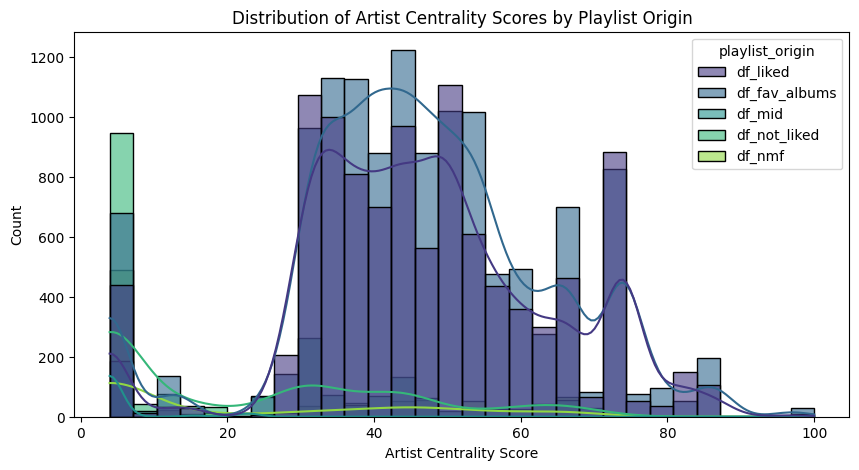

In [58]:
# Set figure size
plt.figure(figsize=(10, 5))

# Plot the distribution of 'Artist Centrality', colored by playlist_origin
# This shows how centrality scores vary across different playlists 🎨
sns.histplot(df, x='Artist Centrality', bins=30, hue='playlist_origin', kde=True, alpha=0.6, palette='viridis')

# Labels and title
plt.xlabel('Artist Centrality Score')
plt.ylabel('Count')
plt.title('Distribution of Artist Centrality Scores by Playlist Origin')

# Show the plot
plt.show()

### Lucy Dacus is one of my most played artists of all time, let's look at what her Pagerank network looked like!

Lucy Dacus's Centrality Score: 3.94
Lucy Dacus's Connections: [('Lucy Dacus', 'Leith Ross'), ('Lucy Dacus', 'The Last Dinner Party'), ('Lucy Dacus', 'Mitski'), ('Lucy Dacus', 'Julien Baker'), ('Lucy Dacus', 'Boygenius'), ('Lucy Dacus', 'Phoebe Bridgers'), ('Lucy Dacus', 'Better Oblivion Community Center'), ('Lucy Dacus', 'Soccer Mommy'), ('Lucy Dacus', 'Hozier'), ('Lucy Dacus', 'Faye Webster'), ('Lucy Dacus', 'Julia Jacklin'), ('Lucy Dacus', 'Maya Hawke'), ('Lucy Dacus', 'Big Red Machine')]


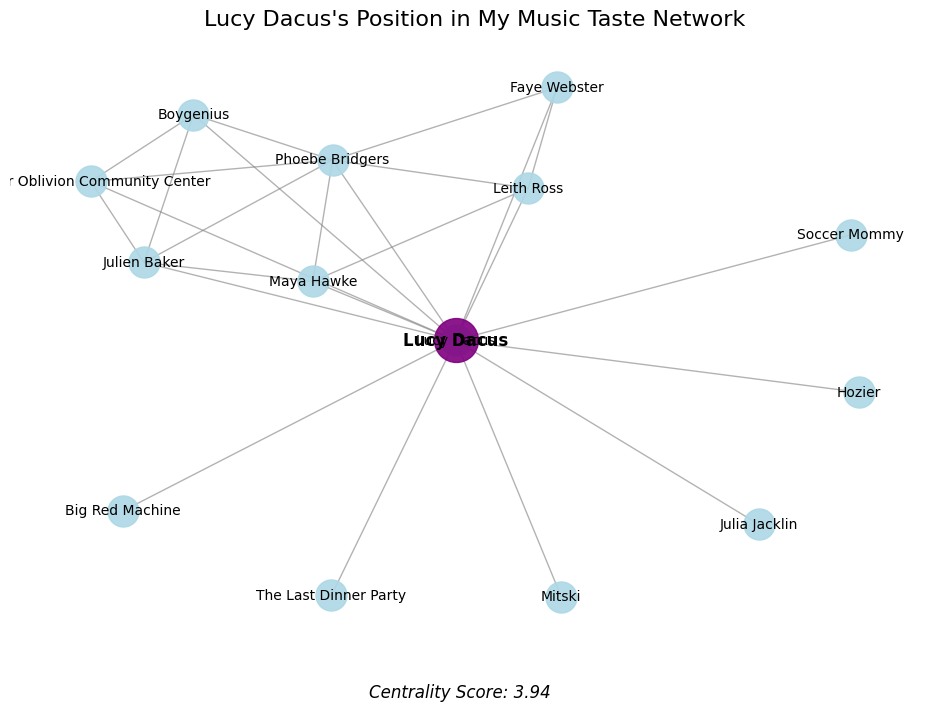

In [60]:
# Extract Lucy Dacus's centrality score
lucy_dacus_centrality = df[df['Artist Name(s)'].str.contains('Lucy Dacus')]['Artist Centrality'].values[0]

# Extract Lucy Dacus's connections from the graph
lucy_dacus_connections = list(G.edges('Lucy Dacus'))

# Print Lucy Dacus's centrality score and connections
print(f"Lucy Dacus's Centrality Score: {lucy_dacus_centrality:.2f}")
print(f"Lucy Dacus's Connections: {lucy_dacus_connections}")

# Create a subgraph centered around Lucy Dacus
lucy_dacus_subgraph = G.subgraph(['Lucy Dacus'] + [artist for edge in lucy_dacus_connections for artist in edge])

# Set up the plot
plt.figure(figsize=(12, 8))

# Draw the network
pos = nx.spring_layout(lucy_dacus_subgraph, seed=42)  # Layout for consistent positioning
nx.draw_networkx_nodes(lucy_dacus_subgraph, pos, node_size=500, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(lucy_dacus_subgraph, pos, edge_color='gray', alpha=0.6)

# Highlight Lucy Dacus
nx.draw_networkx_nodes(lucy_dacus_subgraph, pos, nodelist=['Lucy Dacus'], node_size=1000, node_color='purple', alpha=0.9)
nx.draw_networkx_labels(lucy_dacus_subgraph, pos, labels={'Lucy Dacus': 'Lucy Dacus'}, font_size=12, font_weight='bold')

# Add labels for connected artists
nx.draw_networkx_labels(lucy_dacus_subgraph, pos, font_size=10)

# Add title and annotations
plt.title("Lucy Dacus's Position in My Music Taste Network", fontsize=16)
plt.figtext(0.5, 0.05, f"Centrality Score: {lucy_dacus_centrality:.2f}", ha='center', fontsize=12, style='italic')

# Remove axes
plt.axis('off')

# Show the plot
plt.show()

## Two More Features Before Primetime! 🎭

**Mood Score**: Combines Valence, Danceability, and Liveness to capture the vibe.

**Energy Profile**: Mashes Energy, Loudness, and Tempo to gauge the track’s intensity.


In [62]:
# Calculate features only on non-NMF data
non_nmf_df = df[df['playlist_origin'] != 'df_nmf'].copy()

# Create mood_score and energy_profile on non-NMF data
non_nmf_df['mood_score'] = non_nmf_df[['Valence', 'Danceability', 'Liveness']].mean(axis=1)
non_nmf_df['energy_profile'] = non_nmf_df[['Energy', 'Loudness', 'Tempo']].mean(axis=1)

# Merge these features back into the main dataframe
df = df.merge(non_nmf_df[['mood_score', 'energy_profile']], how='left', left_index=True, right_index=True)

## Previwing the features on the menu 📖

In [64]:
print("Columns in the DataFrame:")
print(df.columns)

print("\nData Types of Each Column:")
print(df.dtypes)

Columns in the DataFrame:
Index(['Track ID', 'Track Name', 'Album Name', 'Artist Name(s)',
       'Release Date', 'Duration (ms)', 'Popularity', 'Genres', 'Record Label',
       'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'liked', 'playlist_origin', 'Primary Artist',
       'Record Label Frequency Encoded', 'Genres_encoded',
       'Featured_Artist(s)', 'Artist Centrality', 'mood_score',
       'energy_profile'],
      dtype='object')

Data Types of Each Column:
Track ID                           object
Track Name                         object
Album Name                         object
Artist Name(s)                     object
Release Date                       object
Duration (ms)                       int64
Popularity                          int64
Genres                             object
Record Label                       object
Danceability                      float64
Energy 

## Standardize the numeric columns 📏
When some numbers have a larger size than others, the model can be biased towards them, so we bring all the numeric columns on a similar scale.

### Seperate New Music Friday and Save it for Later!

In [67]:
# Calculate mood and energy scores first
df['mood_score'] = df[['Valence', 'Danceability', 'Liveness']].mean(axis=1)
df['energy_profile'] = df[['Energy', 'Loudness', 'Tempo']].mean(axis=1)

# Split and save data
df_nmf = df[df['playlist_origin'] == 'df_nmf'].copy()
df = df[df['playlist_origin'] != 'df_nmf'].copy()

# Save both versions pre-standardization
df_nmf.to_csv('data/df_nmf_later.csv', index=False)
df_cleaned_pre_standardized = pd.concat([df, df_nmf], ignore_index=True)
df_cleaned_pre_standardized.to_csv('data/df_cleaned_pre_standardized.csv', index=False)

# Store original values
original_centrality = df_nmf['Artist Centrality'].copy()
original_mood = df_nmf['mood_score'].copy()
original_energy = df_nmf['energy_profile'].copy()

In [68]:
# Define numeric columns to scale
numeric_columns = [ 
    'Genres_encoded', 
    'Artist Centrality',
    'Popularity',
    'Record Label Frequency Encoded', 
    'mood_score', 
    'energy_profile'
]

# Initialize the scaler with a 1 to 100 range
scaler = MinMaxScaler(feature_range=(1, 100))

# Fit the scaler on the training data (df)
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Transform the test data (df_nmf) using the fitted scaler
df_nmf[numeric_columns] = scaler.transform(df_nmf[numeric_columns])

# Save the scaled df_nmf for later use
df_nmf.to_csv('data/df_nmf_later.csv', index=False)

# Display the first few rows of the scaled test data
print("\nScaled Test Data (df_nmf):")
df_nmf[numeric_columns].head()


Scaled Test Data (df_nmf):


,Genres_encoded,Artist Centrality,Popularity,Record Label Frequency Encoded,mood_score,energy_profile
25279,82.958639,64.482823,1.0,1.0,20.02497,29.320828
25280,82.184801,64.482823,1.0,1.0,20.02497,29.320828
25281,83.418751,64.482823,1.0,1.0,20.02497,29.320828
25282,85.997982,64.482823,1.0,1.0,20.02497,29.320828
25283,69.146450,64.482823,1.0,1.0,20.02497,29.320828


## Tuning and Predicting with Random Forest & XGBoost 🌟
In this section, we fine-tune our Random Forest and XGBoost models using randomized search for optimal hyperparameters. The goal? To get the best possible performance in predicting song ratings. After tuning the models, we make predictions on the unseen data, combining both models' results to generate a more accurate score!

In [70]:
def tune_models(df, features, test_size=0.2):
    # Prepare data
    X = df[features]
    y = (df['liked'] - df['liked'].mean()) / df['liked'].std()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Model parameters
    rf_params = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 15),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
    }
    
    xgb_params = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }
    
    # Initialize models
    rf = RandomForestRegressor(random_state=42)
    xgb = XGBRegressor(random_state=42)
    
    # Perform randomized search
    rf_search = RandomizedSearchCV(rf, rf_params, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    
    # Fit models
    rf_search.fit(X_train, y_train)
    xgb_search.fit(X_train, y_train)
    
    # Train final models with best parameters
    best_rf = RandomForestRegressor(**rf_search.best_params_, random_state=42)
    best_xgb = XGBRegressor(**xgb_search.best_params_, random_state=42)
    
    best_rf.fit(X_train, y_train)
    best_xgb.fit(X_train, y_train)
    
    return best_rf, best_xgb, rf_search.best_params_, xgb_search.best_params_, X_test, y_test

def predict_with_tuned_models(best_rf, best_xgb, df_nmf, features, y_mean, y_std):
    # Make predictions
    rf_pred = best_rf.predict(df_nmf[features]) * y_std + y_mean
    xgb_pred = best_xgb.predict(df_nmf[features]) * y_std + y_mean
    
    # Combine predictions
    df_nmf['predicted_score'] = (rf_pred + xgb_pred) / 2
    
    return df_nmf

# Usage
features = [
    'Genres_encoded', 
    'Artist Centrality',  
    'Record Label Frequency Encoded', 
    'mood_score', 
    'Popularity',
    'energy_profile'
]
best_rf, best_xgb, rf_params, xgb_params, X_test, y_test = tune_models(df, features)
df_nmf = predict_with_tuned_models(best_rf, best_xgb, df_nmf, features, df['liked'].mean(), df['liked'].std())

# Output best parameters and feature importances
print(f"Random Forest best parameters: {rf_params}")
print(f"XGBoost best parameters: {xgb_params}")
print(f"Random Forest feature importances: {best_rf.feature_importances_}")
print(f"XGBoost feature importances: {best_xgb.feature_importances_}")

# Feature importance DataFrame
feature_importance = pd.DataFrame({'feature': features, 'importance': best_rf.feature_importances_}).sort_values('importance', ascending=False)
print("Feature importance (Random Forest):")
print(feature_importance)

Random Forest best parameters: {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 253}
XGBoost best parameters: {'colsample_bytree': 0.6053059844639466, 'learning_rate': 0.29266052670545584, 'max_depth': 8, 'n_estimators': 291, 'subsample': 0.7541666010159664}
Random Forest feature importances: [0.28608355 0.26253277 0.20365346 0.06227482 0.12800089 0.05745452]
XGBoost feature importances: [0.22406217 0.21831888 0.20372164 0.09870005 0.17390516 0.08129206]
Feature importance (Random Forest):
                          feature  importance
0                  Genres_encoded    0.286084
1               Artist Centrality    0.262533
2  Record Label Frequency Encoded    0.203653
4                      Popularity    0.128001
3                      mood_score    0.062275
5                  energy_profile    0.057455


# 80/20 Train/Test of The Non NMF Data using RandomForrest and XGBoost

In [72]:
def train_test_model(df, features, rf_params, xgb_params):
    # Only use non-NMF data for training
    train_df = df[df['playlist_origin'] != 'df_nmf'].copy()
    
    # Prepare features and target
    X = train_df[features]
    y = train_df['liked']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize models with the best parameters from tuning
    rf_model = RandomForestRegressor(**rf_params, random_state=42)
    xgb_model = XGBRegressor(**xgb_params, random_state=42)
    
    # Train models
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    # Combine predictions (80/20 weight)
    final_pred = (0.8 * rf_pred) + (0.2 * xgb_pred)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, final_pred)
    r2 = r2_score(y_test, final_pred)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Track Name': train_df.loc[X_test.index, 'Track Name'],
        'Artist Name(s)': train_df.loc[X_test.index, 'Artist Name(s)'],
        'Actual Score': y_test,
        'Predicted Score': final_pred
    })
    
    # Get feature importances
    importances = pd.DataFrame({
        'Feature': features,
        'RF Importance': rf_model.feature_importances_,
        'XGB Importance': xgb_model.feature_importances_
    })
    
    # Print metrics
    print(f"\nModel Performance:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    print("\nTop 10 Predictions vs Actual:")
    print(results_df.sort_values('Predicted Score', ascending=False).head(10))
    
    print("\nFeature Importances:")
    print(importances.sort_values('RF Importance', ascending=False))
    
    return rf_model, xgb_model, results_df, importances

# Usage
features = ['Genres_encoded', 'Artist Centrality', 'Record Label Frequency Encoded', 'mood_score', 'Popularity', 'energy_profile']
rf_model, xgb_model, results, importances = train_test_model(df, features, rf_params, xgb_params)


Model Performance:
Mean Squared Error: 115.86
R² Score: 0.76

Top 10 Predictions vs Actual:
                                             Track Name  \
4404     Look Over Your Shoulder (feat. Kendrick Lamar)   
8019                                     In The Shadows   
1807                                           Nice Guy   
1256                                            Wake Up   
7923                                Cocoa Butter Kisses   
6453                             Strangers in the Night   
4689                                Walking on a String   
2781  Snakes (from the series Arcane League of Legends)   
1231                                       Sore Subject   
1346                                      Hustler Musik   

                             Artist Name(s)  Actual Score  Predicted Score  
4404            Busta Rhymes,Kendrick Lamar         100.0       103.837515  
8019                          Emile Mosseri         100.0       103.764366  
1807                      

## Run the New Music Friday Regression Model

We're using non-NMF data to train Random Forest and XGBoost models to predict how much users will like different tracks. Our improved model includes two key enhancements:

1. **Artist Similarity Boost**: We reward New Music Friday artists that are similar to your liked artists, helping you discover new music that aligns with your established preferences.

2. **Adaptive Ensemble Weighting**: Instead of a fixed 50/50 blend between models, we dynamically adjust weights based on which model performs better for different types of music.

After training, we make predictions for new tracks and calculate confidence intervals to gauge prediction reliability. We then aggregate results by album, factoring in consistency and track count, and sort by weighted score to create a personalized list of top album recommendations.



=== New Music Friday Recommendations (2025-03-28) ===

Total albums: 59
Albums with 5+ tracks: 57
Albums filtered out (< 5 tracks): 2

Top 20 Albums by Average Score:
                                     Artist                Album Name  avg_score  Track_Count
                             chloe moriondo                    oyster     100.00           26
                                  SPELLLING      Portrait of My Heart     100.00           22
                                 Lucy Dacus      Forever Is A Feeling     100.00           65
                   Unknown Mortal Orchestra              IC-02 Bogotá     100.00           24
                                    Wallows                      More     100.00           21
                     Antt Beatz,Boldy James                   Hommage     100.00           11
                             Perfume Genius                     Glory     100.00           33
                                  girlpuppy                 Sweetness     100.00

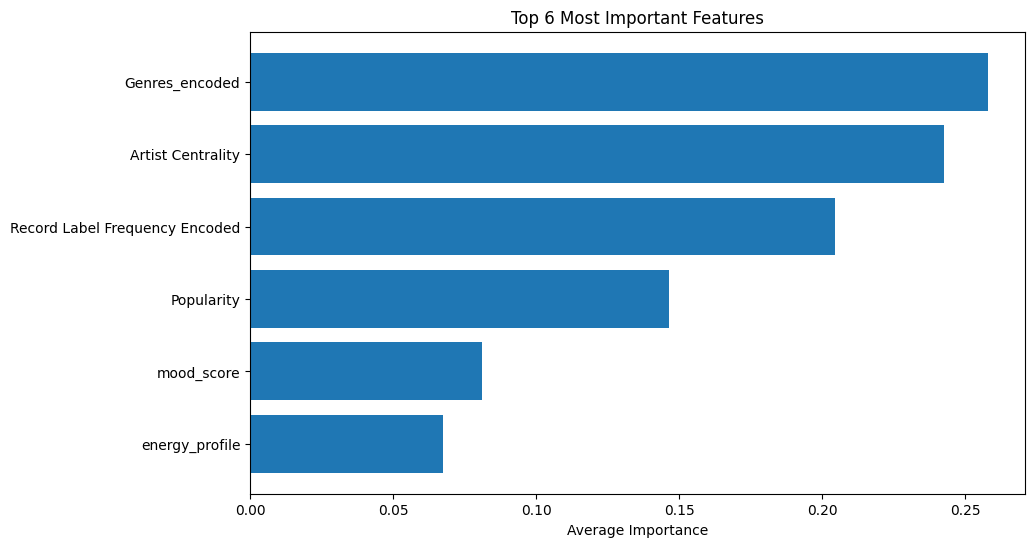

In [74]:
def calculate_adaptive_weights(X_train, y_train, X_pred, rf_model, xgb_model, features, n_bins=5):
    # Make predictions on training data
    rf_train_pred = rf_model.predict(X_train)
    xgb_train_pred = xgb_model.predict(X_train)
    
    # Calculate errors
    rf_errors = np.abs(rf_train_pred - y_train)
    xgb_errors = np.abs(xgb_train_pred - y_train)
    
    # Create a dataframe with features, predictions, and errors
    error_df = X_train.copy()
    error_df['rf_error'] = rf_errors
    error_df['xgb_error'] = xgb_errors
    
    # Get top 2 features by importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    top_features = feature_importance['feature'].head(2).tolist()
    
    # Create bins for each top feature
    for feature in top_features:
        error_df[f'{feature}_bin'] = pd.qcut(error_df[feature], n_bins, labels=False, duplicates='drop')
    
    # Calculate performance by bin
    performance_by_bin = {}
    for feature in top_features:
        performance_by_bin[feature] = {}
        for bin_idx in range(n_bins):
            bin_data = error_df[error_df[f'{feature}_bin'] == bin_idx]
            if len(bin_data) > 0:
                rf_mean_error = bin_data['rf_error'].mean()
                xgb_mean_error = bin_data['xgb_error'].mean()
                total_error = rf_mean_error + xgb_mean_error
                
                if total_error > 0:
                    # Weight inversely proportional to error (higher weight = better model)
                    rf_weight = xgb_mean_error / total_error
                else:
                    rf_weight = 0.5
                
                performance_by_bin[feature][bin_idx] = rf_weight
    
    # Calculate weights for prediction data
    weights = np.ones(len(X_pred)) * 0.5  # Default 50/50 weight
    
    for feature in top_features:
        # Create bins for prediction data
        try:
            pred_bins = pd.qcut(X_pred[feature], n_bins, labels=False, duplicates='drop')
            
            # Apply weights based on bin performance
            for bin_idx in range(n_bins):
                if bin_idx in performance_by_bin[feature]:
                    bin_mask = (pred_bins == bin_idx)
                    if any(bin_mask):
                        rf_weight = performance_by_bin[feature][bin_idx]
                        # Scale weight to 0.3-0.7 range to avoid extreme values
                        scaled_weight = 0.3 + (rf_weight * 0.4)
                        weights[bin_mask] = scaled_weight
        except Exception as e:
            print(f"Warning: Could not calculate bins for {feature}: {e}")
            continue
    
    return weights

def calculate_artist_similarity_boost(df_nmf, df_liked_similar, liked_artists_df, boost_factor=15):
    # Create a copy to avoid modifying the original
    df_nmf_copy = df_nmf.copy()
    
    # Extract primary artists from NMF
    df_nmf_copy['Primary Artist'] = df_nmf_copy['Artist Name(s)'].str.split(',').str[0].str.strip()
    
    # Extract primary artists from liked songs and albums
    liked_artists = set(liked_artists_df['Artist Name(s)'].str.split(',').str[0].str.strip())
    
    # Create a dictionary of similar artists from df_liked_similar
    similar_artists_dict = {}
    for _, row in df_liked_similar.iterrows():
        if pd.notna(row['Similar Artists']):
            artist = row['Artist']
            similar = [s.strip() for s in row['Similar Artists'].split(',')]
            similar_artists_dict[artist] = similar
    
    # Flatten the similar artists dictionary to create a mapping from similar artist to liked artist
    similar_to_liked_mapping = {}
    for liked_artist, similar_list in similar_artists_dict.items():
        for similar_artist in similar_list:
            if similar_artist not in similar_to_liked_mapping:
                similar_to_liked_mapping[similar_artist] = []
            similar_to_liked_mapping[similar_artist].append(liked_artist)
    
    # Function to find the best match for an artist using fuzzy matching
    def find_best_match(artist, artist_set, threshold=85):
        if artist in artist_set:
            return artist, 100
        
        matches = process.extractOne(artist, artist_set)
        if matches and matches[1] >= threshold:
            return matches[0], matches[1]
        return None, 0
    
    # Add similarity boost columns directly to the dataframe
    df_nmf_copy['similarity_boost'] = 0
    df_nmf_copy['match_type'] = 'no_match'
    df_nmf_copy['matched_to'] = 'None'
    
    # Calculate similarity boost for each NMF artist
    for i, row in df_nmf_copy.iterrows():
        artist = row['Primary Artist']
        
        # Check if the artist is directly in liked artists
        if artist in liked_artists:
            df_nmf_copy.at[i, 'similarity_boost'] = boost_factor
            df_nmf_copy.at[i, 'match_type'] = 'direct_match'
            df_nmf_copy.at[i, 'matched_to'] = artist
            continue
        
        # Check if the artist is in similar_to_liked_mapping
        if artist in similar_to_liked_mapping:
            liked_connections = similar_to_liked_mapping[artist]
            df_nmf_copy.at[i, 'similarity_boost'] = boost_factor * 0.8
            df_nmf_copy.at[i, 'match_type'] = 'similar_to_liked'
            df_nmf_copy.at[i, 'matched_to'] = ', '.join(liked_connections[:3])  # Show up to 3 connections
            continue
        
        # Try fuzzy matching with similar artists
        best_match, match_score = find_best_match(artist, set(similar_to_liked_mapping.keys()))
        if best_match:
            liked_connections = similar_to_liked_mapping[best_match]
            df_nmf_copy.at[i, 'similarity_boost'] = boost_factor * 0.6 * (match_score / 100)
            df_nmf_copy.at[i, 'match_type'] = 'fuzzy_similar_match'
            df_nmf_copy.at[i, 'matched_to'] = f"{best_match} ({match_score}%) -> {', '.join(liked_connections[:2])}"
            continue
        
        # Try fuzzy matching with liked artists
        best_match, match_score = find_best_match(artist, liked_artists)
        if best_match:
            df_nmf_copy.at[i, 'similarity_boost'] = boost_factor * 0.7 * (match_score / 100)
            df_nmf_copy.at[i, 'match_type'] = 'fuzzy_direct_match'
            df_nmf_copy.at[i, 'matched_to'] = f"{best_match} ({match_score}%)"
            continue
    
    return df_nmf_copy

# Load the similar artists data
df_liked_similar = pd.read_csv('data/liked_artists_only_similar.csv')

# Filter liked and favorite albums for similarity boost
liked_artists_df = df[df['playlist_origin'].isin(['df_liked', 'df_fav_albums'])]

# Create known artists set
known_artists = set(df_liked_similar['Artist'])

# Features used for prediction
features = [
    'Genres_encoded', 
    'Artist Centrality',  
    'Record Label Frequency Encoded', 
    'mood_score', 
    'Popularity',
    'energy_profile'
]

# Normalize the target variable
y_mean = df['liked'].mean()
y_std = df['liked'].std()
y_normalized = (df['liked'] - y_mean) / y_std

# Prepare training data
X = df[features]
y = y_normalized  # Use normalized target

# Initialize models with the best parameters from tuning
rf_model = RandomForestRegressor(**rf_params, random_state=42)
xgb_model = XGBRegressor(**xgb_params, random_state=42)

# Train models
rf_model.fit(X, y)
xgb_model.fit(X, y)

# Get feature importance from both models
rf_importance = pd.DataFrame({
    'feature': features,
    'importance_rf': rf_model.feature_importances_
}).sort_values('importance_rf', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': features,
    'importance_xgb': xgb_model.feature_importances_
}).sort_values('importance_xgb', ascending=False)

# Combine importance scores
feature_importance = pd.merge(rf_importance, xgb_importance, on='feature')
feature_importance['avg_importance'] = (feature_importance['importance_rf'] + feature_importance['importance_xgb']) / 2
feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

# Prepare NMF data for prediction
df_nmf_cleaned = df_nmf[features]

# Calculate similarity boost for NMF artists
df_nmf = calculate_artist_similarity_boost(df_nmf, df_liked_similar, liked_artists_df)

# Make predictions and denormalize
rf_predictions = rf_model.predict(df_nmf_cleaned) * y_std + y_mean
xgb_predictions = xgb_model.predict(df_nmf_cleaned) * y_std + y_mean

# Calculate adaptive weights for ensemble
adaptive_weights = calculate_adaptive_weights(X, y_normalized, df_nmf_cleaned, rf_model, xgb_model, features)

# Combine predictions with adaptive weights and apply similarity boost
final_predictions = (adaptive_weights * rf_predictions + 
                    (1 - adaptive_weights) * xgb_predictions)
final_predictions = final_predictions + df_nmf['similarity_boost']

# Clip final predictions to ensure no scores exceed 100
final_predictions = np.clip(final_predictions, None, 100)

# Keep track of unknown artists without applying boost
df_nmf['is_unknown_artist'] = ~df_nmf['Artist Name(s)'].isin(known_artists)
df_nmf['predicted_score'] = final_predictions

# Get prediction intervals
def get_prediction_interval(X, model, percentile=95):
    predictions = []
    for estimator in model.estimators_:
        predictions.append(estimator.predict(X) * y_std + y_mean)
    predictions = np.array(predictions)
    lower = np.percentile(predictions, (100-percentile)/2, axis=0)
    upper = np.percentile(predictions, 100-(100-percentile)/2, axis=0)
    return lower, upper

# Calculate prediction intervals
lower_bound, upper_bound = get_prediction_interval(df_nmf_cleaned, rf_model)
df_nmf['prediction_lower'] = lower_bound
df_nmf['prediction_upper'] = upper_bound
df_nmf['prediction_uncertainty'] = upper_bound - lower_bound

# Get the most common release date from NMF dataset
nmf_release_date = df_nmf['Release Date'].mode().iloc[0]

# Function to find common artists across all tracks in an album
def get_common_artists(artist_series):
    """
    Takes a series of comma-separated artist strings and returns only the artists 
    that appear in all tracks of the album.
    """
    # Split each string into a list of artists
    artist_lists = [set(artists.split(',')) for artists in artist_series]
    
    # Find the intersection of all artist sets (artists present in all tracks)
    if artist_lists:
        common_artists = set.intersection(*artist_lists)
        
        # If no common artists (rare case), fall back to the most frequent artist
        if not common_artists:
            # Flatten the list of artists
            all_artists = [artist for sublist in artist_lists for artist in sublist]
            # Count occurrences and get the most frequent
            from collections import Counter
            artist_counts = Counter(all_artists)
            most_common = [artist for artist, count in artist_counts.most_common() 
                          if count == len(artist_series)]
            
            # If there are artists that appear in all tracks, use them
            if most_common:
                common_artists = set(most_common)
            # Otherwise use the most frequent artist
            else:
                most_common_artist = artist_counts.most_common(1)[0][0]
                common_artists = {most_common_artist}
    
        # Join the common artists with commas (no spaces, as per your format)
        return ','.join(sorted(common_artists))
    else:
        return ""

# Group by album and aggregate data
album_predictions = df_nmf.groupby('Album Name').agg({
    'Artist Name(s)': get_common_artists,  # Apply our custom function
    'predicted_score': ['mean', 'std', 'count'],
    'prediction_uncertainty': 'mean',
    'Genres': lambda x: ' | '.join(list(set(x))[:3]),
    'Record Label': 'first',
    'Artist Centrality': 'first', 
    'mood_score': 'first',         
    'energy_profile': 'first',
    'Genres_encoded': 'first',  # Include Genres_encoded
    'Record Label Frequency Encoded': 'first'  # Include Record Label Frequency Encoded
}).reset_index()

# Flatten column names
album_predictions.columns = [
    'Album Name', 'Artist', 'avg_score', 'score_std', 'track_count',
    'avg_uncertainty', 'Genres', 'Label', 'Artist_Centrality', 
    'Mood_Score', 'Energy_Profile', 'Genres_encoded', 
    'Record_Label_Frequency_Encoded'
]

# Calculate confidence score (unchanged)
max_std = album_predictions['score_std'].max()
max_uncertainty = album_predictions['avg_uncertainty'].max()

album_predictions['confidence_score'] = (
    (1 - album_predictions['score_std'] / max_std) * 
    (1 - album_predictions['avg_uncertainty'] / max_uncertainty) * 
    (1 - 1/(1 + album_predictions['track_count']))
) * 100

album_predictions['confidence_score'] = np.clip(
    album_predictions['confidence_score'], a_min=1, a_max=100
)

# Rename track_count to Track_Count in the album_predictions dataframe
album_predictions = album_predictions.rename(columns={'track_count': 'Track_Count'})

# Filter out albums with fewer than 5 tracks
album_predictions_filtered = album_predictions[album_predictions['Track_Count'] >= 5].copy()

# Sort by average score
album_recommendations = album_predictions_filtered.sort_values('avg_score', ascending=False)

# Define output columns with original values and add Track_Count
output_columns = [
    'Artist', 'Album Name', 'avg_score', 'confidence_score',
    'Track_Count', 'Genres', 'Label', 'Artist_Centrality', 
    'Mood_Score', 'Energy_Profile', 'Genres_encoded', 
    'Record_Label_Frequency_Encoded'
]

# Format the date for the filename
date_str = datetime.strptime(nmf_release_date, '%Y-%m-%d').strftime('%m-%d-%y')
filename = f"{date_str}_Album_Recommendations.csv"

# Save recommendations with rounded numbers and scale adjustments
final_recommendations = album_recommendations[output_columns].copy()
final_recommendations['Artist_Centrality'] = final_recommendations['Artist_Centrality']  
final_recommendations['Mood_Score'] = final_recommendations['Mood_Score'].clip(1, 100)  
final_recommendations['Energy_Profile'] = final_recommendations['Energy_Profile'].clip(1, 100)  

final_recommendations.round(2).to_csv(f'predictions/{filename}', index=False)

# Define the custom scorer for cross-validation
def custom_scorer(y_true, y_pred):
    y_true_denormalized = y_true * y_std + y_mean
    y_pred_denormalized = y_pred * y_std + y_mean
    return -mean_squared_error(y_true_denormalized, y_pred_denormalized)

# Wrap the custom scorer
custom_scorer_func = make_scorer(custom_scorer, greater_is_better=False)

# Evaluate models using cross-validation
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring=custom_scorer_func)
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=custom_scorer_func)

# Print results with improved formatting
print(f"\n=== New Music Friday Recommendations ({nmf_release_date}) ===\n")

# Count of albums filtered out
albums_filtered_out = len(album_predictions) - len(album_predictions_filtered)
print(f"Total albums: {len(album_predictions)}")
print(f"Albums with 5+ tracks: {len(album_predictions_filtered)}")
print(f"Albums filtered out (< 5 tracks): {albums_filtered_out}\n")

# Display top 20 recommended albums with clean formatting
print("Top 20 Albums by Average Score:")
display_cols = ['Artist', 'Album Name', 'avg_score', 'Track_Count']
print(album_recommendations[display_cols].head(20).round(2).to_string(index=False))

# Print model performance metrics
print("\n=== Model Performance ===")
print(f"Random Forest CV Score: {rf_cv_scores.mean():.3f} (+/- {rf_cv_scores.std() * 2:.3f})")
print(f"XGBoost CV Score: {xgb_cv_scores.mean():.3f} (+/- {xgb_cv_scores.std() * 2:.3f})")

# Display feature importance
print("\n=== Feature Importance ===")
print(feature_importance[['feature', 'avg_importance']].round(3).to_string(index=False))

# Visualization for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['avg_importance'])
plt.xlabel('Average Importance')
plt.title('Top 6 Most Important Features')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Display the Top Recommended Albums!

In [76]:
# Folder where the predictions are saved
predictions_folder = "predictions/"

# Get the latest predictions file
files = [f for f in os.listdir(predictions_folder) if f.endswith("_Album_Recommendations.csv")]

if files:
    thisweek = max(files, key=lambda f: os.path.getmtime(os.path.join(predictions_folder, f)))
    print(f"Loaded latest file: {thisweek}")  # Optional, just for confirmation
    model_output_df = pd.read_csv(os.path.join(predictions_folder, thisweek))
    model_output_df = model_output_df.sort_values(by="avg_score", ascending=False)

    # Display all rows
    pd.set_option("display.max_rows", None)
    model_output_df
else:
    thisweek = None
    None  # Ensures no unwanted output

thisweek  # Stores the filename for reference
model_output_df  #Show the Recommendations Dataframe for This Past Week!

Loaded latest file: 03-28-25_Album_Recommendations.csv


,Artist,Album Name,avg_score,confidence_score,Track_Count,Genres,Label,Artist_Centrality,Mood_Score,Energy_Profile,Genres_encoded,Record_Label_Frequency_Encoded
0,chloe moriondo,oyster,100.00,96.30,26,"indie rock, pop punk, 4, 20s, bedroom pop, 202...",Fueled by Ramen / Public Consumption,29.38,55.36,42.42,83.88,1.00
1,SPELLLING,Portrait of My Heart,100.00,1.00,22,"2025, female vocalist, art pop, ethereal wave ...",Sacred Bones Records,36.13,42.96,60.52,58.33,1.71
2,Lucy Dacus,Forever Is A Feeling,100.00,97.73,65,"2018, indie rock, indie, female vocalists, sin...","Lucy Dacus, under exclusive license to Geffen ...",64.48,20.02,29.32,82.96,1.00
3,Unknown Mortal Orchestra,IC-02 Bogotá,100.00,65.20,24,"2018, rock, psychedelic rock, umo | 2015, best...",Jagjaguwar,36.04,65.26,57.03,61.15,83.92
4,Wallows,More,100.00,47.80,21,"2019, indie rock, rock, alternative, indie pop...",Atlantic Records,46.68,59.49,61.96,78.89,39.92
5,"Antt Beatz,Boldy James",Hommage,100.00,88.75,11,"rap, hip-hop, gangsta rap, hip hop, detroit, j...",Boldy James / Antt Beatz / EMPIRE,29.50,70.06,78.74,66.27,1.00
6,Perfume Genius,Glory,100.00,92.06,33,"singer-songwriter, ambient, experimental, indi...",Matador,42.96,32.00,47.51,62.81,58.54
7,girlpuppy,Sweetness,100.00,94.74,18,"female vocalist, indie pop, electronic, indie,...",Captured Tracks,41.48,7.56,43.64,80.12,1.28
8,Great Grandpa,"Patience, Moonbeam",99.92,57.51,36,"female vocalist, indie rock, indie, noise pop,...",Run For Cover Records,44.53,12.76,53.59,83.67,11.58
9,Will Smith,Based on a True Story,99.91,1.00,14,"hip-hop, rap, pop, hip hop, rnb, will smith, a...",SLANG X Influence,10.70,86.64,45.14,69.45,1.00


## Grab Album Art for the NMF Albums

In [78]:
# My Last.fm API key
LASTFM_API_KEY = "74a510ecc9fc62bf3e0edc6adc2e99f9"

# Function to get similar artists using Last.fm API
def get_similar_artists(artist: str, api_key: str, limit: int = 5) -> dict:
    base_url = "http://ws.audioscrobbler.com/2.0/"
    params = {
        'method': 'artist.getsimilar',
        'artist': artist,
        'api_key': api_key,
        'limit': limit,
        'format': 'json'
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if 'similarartists' in data and 'artist' in data['similarartists']:
            similar_artists = [artist['name'] for artist in data['similarartists']['artist']]
            return {'Artist': artist, 'Similar Artists': ", ".join(similar_artists[:limit]), 'status': 'success'}
    except Exception as e:
        return {'Artist': artist, 'Similar Artists': None, 'status': f'error: {str(e)}'}
    
    return {'Artist': artist, 'Similar Artists': None, 'status': 'no_results'}

# Function to get album art using Apple Music API
def get_album_art(artist: str, album: str) -> dict:
    try:
        url = f"https://itunes.apple.com/search?term={artist} {album}&entity=album"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        if 'results' in data and len(data['results']) > 0:
            album_art = data['results'][0].get('artworkUrl100', '').replace("100x100", "600x600")
            return {'Artist': artist, 'Album Name': album, 'Album Art': album_art, 'status': 'success'}
    except Exception as e:
        return {'Artist': artist, 'Album Name': album, 'Album Art': None, 'status': f'error: {str(e)}'}
    
    return {'Artist': artist, 'Album Name': album, 'Album Art': None, 'status': 'no_results'}

# Main function to update album data
def update_album_data(input_file: str, album_art_file: str, similar_artists_file: str, api_key: str) -> None:
    print(f"\nStarting data fetch at {datetime.now().strftime('%H:%M:%S')}")
    df_input = pd.read_csv(input_file)
    album_pairs = df_input[['Primary Artist', 'Album Name']].drop_duplicates()
    recommended_artists = df_input[df_input['playlist_origin'] == 'df_nmf']['Primary Artist'].unique()
    
    try:
        existing_album_art = pd.read_csv(album_art_file)
    except FileNotFoundError:
        existing_album_art = pd.DataFrame(columns=['Artist', 'Album Name', 'Album Art'])
    
    album_pairs = album_pairs.merge(
        existing_album_art,
        left_on=['Primary Artist', 'Album Name'],
        right_on=['Artist', 'Album Name'],
        how='left',
        indicator=True
    )
    album_pairs = album_pairs[album_pairs['_merge'] == 'left_only'].drop(columns=['_merge', 'Album Art'])
    
    df_album_art = pd.DataFrame(columns=['Artist', 'Album Name', 'Album Art'])
    df_similar = pd.DataFrame(columns=['Artist', 'Similar Artists'])
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_album = {
            executor.submit(get_album_art, row['Primary Artist'], row['Album Name']): (row['Primary Artist'], row['Album Name'])
            for _, row in album_pairs.iterrows()
        }
        for future in as_completed(future_to_album):
            result = future.result()
            if result['status'] == 'success' and result['Album Art']:
                df_album_art = pd.concat([df_album_art, pd.DataFrame([result])], ignore_index=True)
            sleep(0.25)
    
    updated_album_art = pd.concat([existing_album_art, df_album_art], ignore_index=True)
    updated_album_art.to_csv(album_art_file, index=False)
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_artist = {
            executor.submit(get_similar_artists, artist, api_key): artist
            for artist in recommended_artists
        }
        for future in as_completed(future_to_artist):
            result = future.result()
            if result['status'] == 'success' and result['Similar Artists']:
                df_similar = pd.concat([df_similar, pd.DataFrame([result])], ignore_index=True)
            sleep(0.25)
    
    df_similar.to_csv(similar_artists_file, index=False)
    print(f"\nFinished at {datetime.now().strftime('%H:%M:%S')}")

# Usage
if __name__ == "__main__":
    input_file = "data/df_nmf_later.csv"  
    album_art_file = "data/nmf_album_covers.csv"  
    similar_artists_file = "data/nmf_similar_artists.csv"  
    update_album_data(input_file, album_art_file, similar_artists_file, LASTFM_API_KEY)


Starting data fetch at 16:26:00

Finished at 16:27:03


## Grab the Spotify Link for each New Music Friday Album 🔗

In [80]:
def generate_spotify_links():
    # Initialize Spotify client with your credentials
    client_id = "71faef9605da4db495b691d96a0daa4b"
    client_secret = "832e40da22e049bba93f29d9dbeb2e62"
    
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
        client_id=client_id,
        client_secret=client_secret
    ))
    
    # Read the NMF data
    df = pd.read_csv('data/nmf.csv')
    
    # Get unique albums
    albums = df.drop_duplicates(subset=['Album Name'], keep='first')
    
    # Function to get album ID from track with rate limiting
    def get_album_id(track_id):
        try:
            # Add delay to respect rate limits
            time.sleep(0.1)  # 100ms delay between requests
            track_info = sp.track(track_id)
            return track_info['album']['id']
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:  # Too Many Requests
                print("Rate limit hit, waiting longer...")
                time.sleep(5)  # Wait 5 seconds before retrying
                try:
                    track_info = sp.track(track_id)
                    return track_info['album']['id']
                except:
                    print(f"Still failed after retry for track {track_id}")
                    return None
            else:
                print(f"Error getting album ID for track {track_id}: {e}")
                return None
        except Exception as e:
            print(f"Unexpected error for track {track_id}: {e}")
            return None
    
    print(f"Processing {len(albums)} albums...")
    
    # Get album IDs and generate URLs
    albums['Album ID'] = albums['Track ID'].apply(get_album_id)
    
    # Filter out any failed lookups
    albums = albums.dropna(subset=['Album ID'])
    
    albums['Spotify URL'] = 'open.spotify.com/album/' + albums['Album ID'].astype(str)
    
    # Select and reorder columns for output
    output_df = albums[['Album Name', 'Artist Name(s)', 'Album ID', 'Spotify URL']]
    
    # Save to CSV
    output_df.to_csv('data/nmf_album_links.csv', index=False)
    
    print(f"Successfully generated album links for {len(output_df)} albums")
    return output_df

if __name__ == "__main__":
    generate_spotify_links()

Processing 61 albums...
Successfully generated album links for 61 albums


## Save a HTML copy of this notebook at its newest! 🔽

In [82]:
# Ensure the 'graphics/' directory exists
os.makedirs('graphics', exist_ok=True)

# Load the current notebook with 'utf-8' encoding
notebook_filename = 'Music Taste Machine Learning Data Prep.ipynb'
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)

# Export the notebook as HTML
html_exporter = HTMLExporter()
html_data, resources = html_exporter.from_notebook_node(notebook_content)

# Save the HTML to the 'graphics/' folder
output_filename = 'graphics/Music_Taste_Machine_Learning_Data_Prep.html'
with open(output_filename, 'w', encoding='utf-8') as f:
    f.write(html_data)

print(f"HTML version saved to {output_filename}")

HTML version saved to graphics/Music_Taste_Machine_Learning_Data_Prep.html
